In [1]:
import xtrack as xt
import numpy as np
import bpmeth
import matplotlib.pyplot as plt
from cpymad.madx import Madx
import sympy as sp
import pandas as pd
import scipy as sc



In [2]:
##########################
# ELENA lattice in MAD-X #
##########################

madx = Madx()
madx.call("../ELENA/ring/acc-models-elena/elena.seq")
madx.call("../ELENA/ring/acc-models-elena/elena.dbx")
madx.call("../ELENA/ring/acc-models-elena/tools/splitEle_installBPM.madx")
madx.call("../ELENA/ring/acc-models-elena/scenarios/highenergy/highenergy.str")
madx.call("../ELENA/ring/acc-models-elena/scenarios/highenergy/highenergy.beam")
madx.use("elena")



  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.03  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2024.04.25               +
  + Execution date: 2026.02.03 17:46:29      +
  ++++++++++++++++++++++++++++++++++++++++++++
! ELENA ring Sequence -> LNR

!

!

! Changelog:

! -  5/06/2018: started with Pavel''s optics

!   - cleaned up some commented lines and added some markers

!   - redefined randomly some names of the e-cool solenoids

!   - TODO: 

!      - cleanup useless lines. re-arrange markers "badly" used here and there.

!      - rename non-existing quad 631 and 626 !!!

! - 24/11/2020: adjusted structure to new standards. Still a lot of work to do to make it LDB compatible.

! - Sep 2021: moving toward LDB-compatible model

!

! TODO: probably need to work on arc lenght for dipoles to match GEODE/drawings/LDB.





/************************************************************************************/

/*            

In [3]:
#########################
# ELENA model in XSuite #
#########################

line_mad = xt.Line.from_madx_sequence(madx.sequence.elena, deferred_expressions=True)
start_elem = "lnr.vvgbf.0114"
line_mad.cycle(name_first_element=start_elem, inplace=True)  # Such that dipole is not spanning over end-beginning of lattice
line_mad.particle_ref = xt.Particles(p0c=0.1e9, mass0=0.938272e9+2*511e3, q0=-1)
line_mad.configure_bend_model(core='adaptive', edge='full')
line_mad.configure_drift_model("exact")
tw = line_mad.twiss4d()
# tw.plot()


Converting sequence "elena": 100%|██████████| 191/191 [00:00<00:00, 919.53it/s] 


In [4]:
############################
# Magnet design parameters #
############################

phi = 60/180*np.pi
rho = 0.927  # https://edms.cern.ch/ui/file/1311860/2.0/LNA-MBHEK-ER-0001-20-00.pdf
dipole_h = 1/rho
l_magn = rho*phi
gap=0.076
theta_E = 17/180*np.pi
fint = 0.424
B_dip_T = 0.42881  # Design dipole field in Tesla

(-15.0, 20.0)

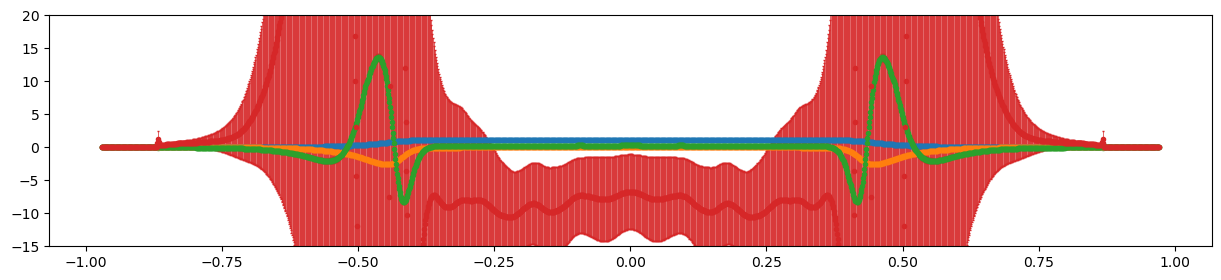

In [5]:
############################################# 
# bpmeth dipole fieldmap model with splines #
#############################################

data = np.loadtxt("../ELENA/dipole/ELENA_fieldmap.csv", skiprows=1, delimiter=",")[:, [0,1,2,7,8,9]]  # Fieldmap in Tesla
Brho = B_dip_T * rho  # T.m
dipole = bpmeth.Fieldmap(data)
dipole.rescale(1/Brho)

radius=0.0025
dipole_FS = dipole.calc_FS_coords(XFS=np.linspace(-0.025, 0.025, 51), YFS=[0], SFS=np.arange(-l_magn, l_magn, 0.001), rho=rho, phi=phi, radius=radius)
dipole_FS = dipole_FS.symmetrize(radius=radius)
fig, ax = plt.subplots(figsize=(15, 3))
zvals, coeffs, coeffsstd = dipole_FS.z_multipoles(3, ax=ax)
ax.set_ylim(-15, 20)

In [6]:
allowed_length = line_mad["drift_18"].length*2 + line_mad["lnr.mbhek.0245.h1"].length*2  # This is the space available in the ring for the dipole until the next element, so the fringes overlap!
print("Total allowed length of the dipole:", allowed_length)
print("Half the allowed magnet length: ", allowed_length/2)

Total allowed length of the dipole: 1.5699521299592458
Half the allowed magnet length:  0.7849760649796229


In [7]:
max_multipole = 3
fringe1_start = -0.76
fringe1_end = -0.35
magnet_start = -0.78

fringe2_start = -fringe1_end
fringe2_end = -fringe1_start

n_splits = 11
step = (np.abs(zvals-fringe1_end).argmin() - np.abs(zvals-fringe1_start).argmin()) // n_splits
split1_inds = np.sort([np.abs(zvals-fringe1_start).argmin() + i*step for i in range(n_splits+1)])
split2_inds = np.sort([np.abs(zvals-fringe2_end).argmin() - i*step for i in range(n_splits+1)])

start1_ind = split1_inds[0]
end1_ind = split1_inds[-1]
start2_ind = split2_inds[0]
end2_ind = split2_inds[-1]
magnet_start_ind = np.abs(zvals-magnet_start).argmin()
magnet_end_ind = np.abs(zvals+magnet_start).argmin()

In [8]:
i1, i2 = split1_inds[-1], split2_inds[0]
body_fields = [dipole_h, 
               np.trapezoid(coeffs[i1:i2+1, 1], zvals[i1:i2+1]) / (zvals[i2]-zvals[i1]), 
               np.trapezoid(coeffs[i1:i2+1, 2], zvals[i1:i2+1]) / (zvals[i2]-zvals[i1]),
               np.trapezoid(coeffs[i1:i2+1, 3], zvals[i1:i2+1]) / (zvals[i2]-zvals[i1])
]
print(body_fields)

[1.0787486515641855, np.float64(-0.0185437542523993), np.float64(0.23396468447612828), np.float64(-8.559605077371572)]


In [9]:
all_pols = []
for index in range(max_multipole):
    # The actual data
    b = coeffs[:, index]
    dz = np.diff(zvals, prepend=zvals[0])
    bp = np.nan_to_num(np.diff(b,prepend=b[0])/dz, copy=True)
    
    # The points to fit
    x = zvals.copy()
    y = b.copy()
    y[start1_ind] = 0  # Force field to be zero at the start of the fringe
    y[end1_ind] = body_fields[index]  # Force field to be equal to body value at the end of the fringe
    y[start2_ind] = body_fields[index]  
    y[end2_ind] = 0
    
    yp = bp.copy()
    yp[start1_ind] = 0  # Force derivative to be zero at the start of the fringe
    yp[end1_ind] = 0  # Force derivative to be zero at the end of the fringe
    yp[start2_ind] = 0
    yp[end2_ind] = 0

    pols = [np.zeros(4)]
    for ia,ib in zip(split1_inds[:-1],split1_inds[1:]):
        pol=bpmeth.fit_segment(ia,ib,x,y,yp)        
        pols.append(pol)
    pols.append(np.array([body_fields[index], 0, 0, 0]))
    for ia,ib in zip(split2_inds[:-1],split2_inds[1:]):
        pol=bpmeth.fit_segment(ia,ib,x,y,yp)        
        pols.append(pol)
    pols.append(np.zeros(4))
    all_pols.append(pols)
    
    
segments = []
segment_inds = []
segments.append((zvals[magnet_start_ind], zvals[start1_ind]))
segment_inds.append([magnet_start_ind, start1_ind])
for ia,ib in zip(split1_inds[:-1],split1_inds[1:]):
    segment_inds.append([ia, ib])
    segments.append([zvals[ia], zvals[ib]])
segment_inds.append([end1_ind, start2_ind])
segments.append((zvals[end1_ind], zvals[start2_ind]))
for ia,ib in zip(split2_inds[:-1],split2_inds[1:]):
    segment_inds.append([ia, ib])
    segments.append([zvals[ia], zvals[ib]])
segments.append((zvals[end2_ind], zvals[magnet_end_ind]))
segment_inds.append([end2_ind, magnet_end_ind])

all_pols = np.array(all_pols)  # Shape (n_multipoles, n_segments, 4)

/tmp/silke/ipykernel_423482/2008137931.py:6: RuntimeWarning: invalid value encountered in divide
  bp = np.nan_to_num(np.diff(b,prepend=b[0])/dz, copy=True)


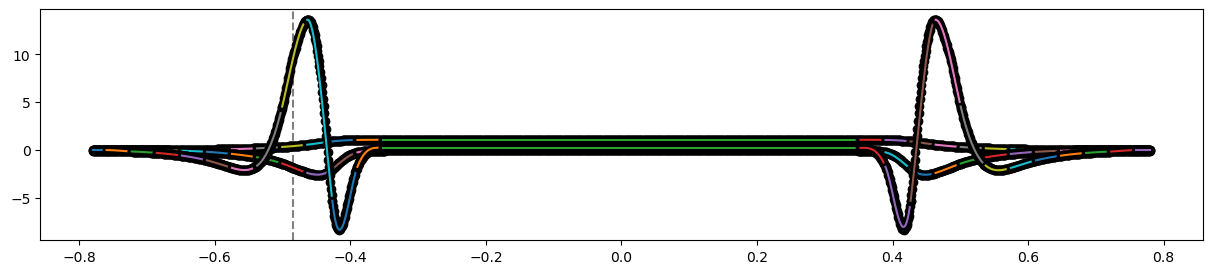

In [10]:
fig, ax = plt.subplots(figsize=(15, 3))
plt.axvline(x=-l_magn/2, color="gray", linestyle="--")
for index in range(max_multipole):
    pols = []
    
    # The actual data
    b = coeffs[:, index]
    
    for (ia, ib), pol in zip(segment_inds, all_pols[index]):
        bpmeth.plot_fit(ia,ib,zvals,b,pol,ax=ax,data=True)

In [11]:
def pol_to_comp(pols):
    """
    :param part: xt.Particles
    :param pols: Polynomial coefficients for this segment, first index is the multipole order (only normal components) b1, b2, b3..., 
        second index is the order of the term in the cubic polynomial (zero = constant)
    """
    
    # comp has bs, b1, a1, b2, a2, ... as first index, and the order of the term in the cubic polynomial as second index (zero = constant)
    comp = np.zeros((9, 4), dtype=np.float64) 
     
    for mult in range(len(pols)):
        comp[2*mult+1] = pols[mult]
    
    return comp

In [12]:
class Magnet:
    isthick=True
    def __init__(self, segments, all_pols, z_edge, rho, ds=0.01):
        """
        :param segments: List of (a,b) tuples defining the segments along z, entrance half of the magnet.
        :param all_pols: For each multipole, list of lists of polynomials for each segment, entrance half 
            of the magnet. The order of the multipoles is len(all_pols).
        :param z_edge: Longitudinal position of the edge of the magnet, to determine curvature.
        :param rho: Bending radius of the magnet.
        """
        self.segments = segments
        self.all_pols = all_pols
        
        self.z_edge = z_edge
        self.rho = rho
        
        self.order = len(all_pols)  
            
        self.length = segments[-1][1] - segments[0][0]
        self.build_tracker()
        self.ds = ds
        
    def build_tracker(self):
        self.polysegments = []
        for i, segment in enumerate(self.segments):
            comp = pol_to_comp(self.all_pols[:, i])
            
            if segment[0] < -self.z_edge:
                h = 0.  # Magic, this has to be a float otherwise it is extremely slow
                s_start = segment[0]
                s_end = np.min([segment[1], -self.z_edge])
                self.polysegments.append(bpmeth.PolySegment(length=s_end - s_start, h=h, comp=comp, s_start = s_start))
            if segment[1] > -self.z_edge and segment[0] < self.z_edge:
                h = 1/self.rho
                s_start = np.max([segment[0], -self.z_edge])
                s_end = np.min([segment[1], self.z_edge])
                self.polysegments.append(bpmeth.PolySegment(length=s_end - s_start, h=h, comp=comp, s_start = s_start))
            if segment[1] > self.z_edge:
                h = 0.
                s_start = np.max([segment[0], self.z_edge])
                s_end = segment[1]
                self.polysegments.append(bpmeth.PolySegment(length=s_end - s_start, h=h, comp=comp, s_start = s_start))
        
    def rescale(self, scalefactor):
        self.all_pols = np.array([[pol*scalefactor for pol in pols] for pols in self.all_pols])
        self.build_tracker()
        return self
        
    def copy(self):
        return Magnet(self.segments, self.all_pols, self.z_edge, self.rho)
    
    def track(self, particles):
        for i, polysegment in enumerate(self.polysegments):
            polysegment.track(particles, ds=self.ds)
            
    def track_step_by_step(self, particles):
        out = []
        for polysegment in self.polysegments:
            seg_out = polysegment.track_step_by_step(particles, ds=self.ds)
            out.extend(seg_out)
        return out
    
    def track_segment_by_segment(self, particles):
        out = [particles.copy()]
        for polysegment in self.polysegments:
            polysegment.track(particles, ds=self.ds)
            out.append(particles.copy())
        return out
        
        
            

In [17]:
Melvin = Magnet(segments, all_pols, l_magn/2, rho, 0.001)

In [19]:
def objective(scalefactor):
    print("Trying scal factor:", scalefactor, end='\r')
    pp = xt.Particles(s=magnet_start)
    magnet = Melvin.copy()
    magnet.rescale(scalefactor)
    magnet.track(pp)
    return abs(np.mean(pp.x))

bounds = (1.0088, 1.0095)
result = sc.optimize.minimize_scalar(objective, bounds=bounds, method="bounded", options={"xatol":1e-8})
scalefactor = result.x
print(f"Best scale factor: {scalefactor}")
print(f"Resulting (absolute value) closed orbit at exit: {objective(scalefactor)} m")

Melvin.rescale(scalefactor)

Best scale factor: 1.00927184144639488
Resulting (absolute value) closed orbit at exit: 8.249856217773377e-10 m


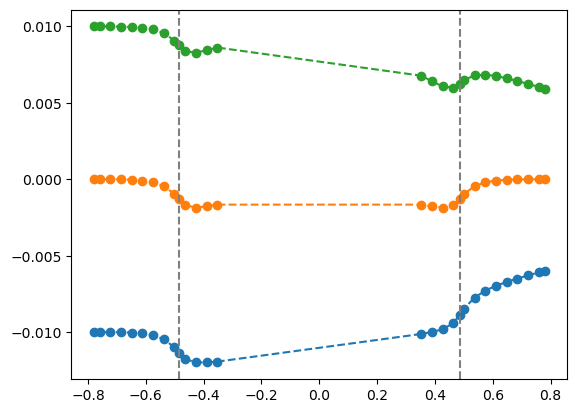

In [20]:
pp = xt.Particles(s=magnet_start, x=[-0.01, 0, 0.01])
out = Melvin.track_segment_by_segment(pp)
plt.plot([p.s for p in out], [p.x for p in out], marker='o', ls='--')
plt.axvline(x=-l_magn/2, color="gray", ls="--")
plt.axvline(x=l_magn/2, color="gray", ls="--")


## Convergence properties

In [21]:
npart = 20
n_ds = 6
x_errors = np.zeros((n_ds, npart))
y_errors = np.zeros((n_ds, npart))
px_errors = np.zeros((n_ds, npart))
py_errors = np.zeros((n_ds, npart))
zeta_errors = np.zeros((n_ds, npart))
delta_errors = np.zeros((n_ds, npart))

x = 0.2*np.random.rand(npart)-0.1
px = 0.2*np.random.rand(npart)-0.1
y = 0.2*np.random.rand(npart)-0.1
py = 0.2*np.random.rand(npart)-0.1
delta = 0.1*np.random.rand(npart)-0.05
zeta = 0.1*np.random.rand(npart)-0.1
part = xt.Particles(s=magnet_start, x=x, px=px, y=y, py=py, delta=delta, zeta=zeta)

for i, ds_pow in enumerate(np.arange(-1, -n_ds-1, -1)):
    ds = 10.**ds_pow
    pp = part.copy()
    Melvin.ds = ds
    Melvin.track(pp)
    pp2 = part.copy()
    Melvin.ds = ds/2
    Melvin.track(pp2)
    x_errors[i] = abs((pp.x - pp2.x) / pp2.x)
    y_errors[i] = abs((pp.y - pp2.y) / pp2.y)
    px_errors[i] = abs((pp.px - pp2.px) / pp2.px)
    py_errors[i] = abs((pp.py - pp2.py) / pp2.py)
    zeta_errors[i] = abs((pp.zeta - pp2.zeta) / pp2.zeta)
    delta_errors[i] = abs((pp.delta - pp2.delta) / pp2.delta)
    
    

/tmp/silke/ipykernel_294338/1256342853.py:20: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[2, 1].set_yscale("log")


Text(0, 0.5, 'ddelta/delta')

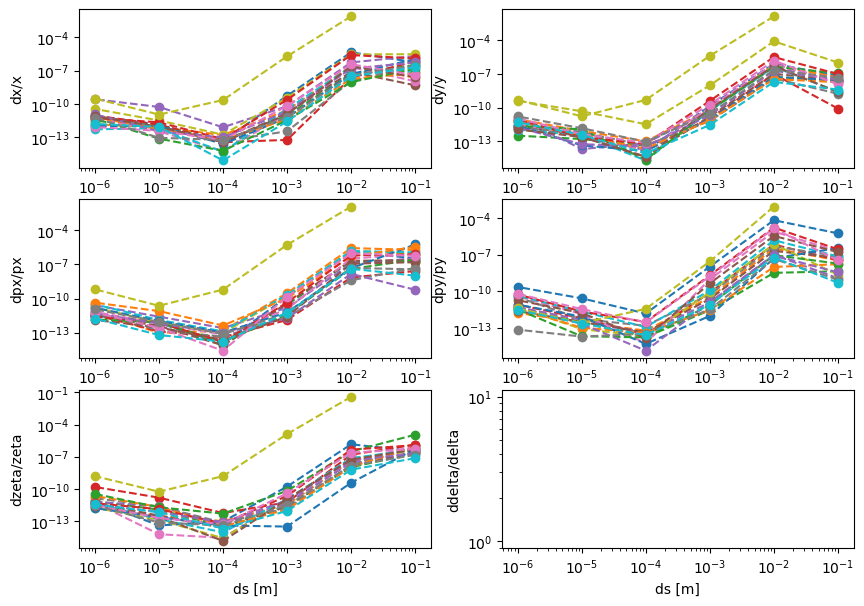

In [23]:
fig, ax = plt.subplots(3, 2, figsize=(10, 7))
for i in range(npart):
    ax[0, 0].plot(10.**np.arange(-1, -n_ds-1, -1), x_errors[:, i], marker='o', ls='--', label=f'Particle {i+1}')
    ax[0, 1].plot(10.**np.arange(-1, -n_ds-1, -1), y_errors[:, i], marker='o', ls='--', label=f'Particle {i+1}')
    ax[1, 0].plot(10.**np.arange(-1, -n_ds-1, -1), px_errors[:, i], marker='o', ls='--', label=f'Particle {i+1}')
    ax[1, 1].plot(10.**np.arange(-1, -n_ds-1, -1), py_errors[:, i], marker='o', ls='--', label=f'Particle {i+1}')
    ax[2, 0].plot(10.**np.arange(-1, -n_ds-1, -1), zeta_errors[:, i], marker='o', ls='--', label=f'Particle {i+1}')
    ax[2, 1].plot(10.**np.arange(-1, -n_ds-1, -1), delta_errors[:, i], marker='o', ls='--', label=f'Particle {i+1}')
ax[0, 0].set_xscale("log")
ax[0, 0].set_yscale("log")
ax[0, 1].set_xscale("log")
ax[0, 1].set_yscale("log")
ax[1, 0].set_xscale("log")
ax[1, 0].set_yscale("log")
ax[1, 1].set_xscale("log")
ax[1, 1].set_yscale("log")
ax[2, 0].set_xscale("log")
ax[2, 0].set_yscale("log")
ax[2, 1].set_xscale("log")
ax[2, 1].set_yscale("log")
ax[0, 0].set_xlabel("ds [m]")
ax[0, 0].set_ylabel("dx/x")
ax[0, 1].set_xlabel("ds [m]")
ax[0, 1].set_ylabel("dy/y")
ax[1, 0].set_xlabel("ds [m]")
ax[1, 0].set_ylabel("dpx/px")
ax[1, 1].set_xlabel("ds [m]")
ax[1, 1].set_ylabel("dpy/py")
ax[2, 0].set_xlabel("ds [m]")
ax[2, 0].set_ylabel("dzeta/zeta")
ax[2, 1].set_xlabel("ds [m]")
ax[2, 1].set_ylabel("ddelta/delta")
